Consider the piezo-electric coupled equations

$$
T = c^E \frac{\partial u}{\partial x} + e \frac{\partial \phi}{\partial x} \\
D = e \frac{\partial u}{\partial x} - \epsilon^S \frac{\partial \phi}{\partial x}
$$

We can combine this with the equation of motion

$$
\frac{\partial T}{\partial x} = \rho \frac{\partial^2 u}{\partial t^2}
$$

and the zero gradient of the electric displacement
$$
\frac{\partial D}{\partial x} = 0
$$

to obtain 
$$ \label{eq:inhom_piezo_stat}
\frac{\partial}{\partial x}(c^E \frac{\partial u}{\partial x}) + \frac{\partial}{\partial x} (e \frac{\partial \phi}{\partial x}) = \rho \frac{\partial^2 u}{\partial t^2} = -\rho \omega^2 u \\
\frac{\partial}{\partial x}(e \frac{\partial u}{\partial x}) - \frac{\partial}{\partial x}(\epsilon^S \frac{\partial \phi}{\partial x}) = 0
$$

We can use the 1D FD system matrix derived for equations of the form 

$$
\frac{\partial}{\partial x}\left(k \frac{\partial y}{\partial x}\right) = M \mathbf{y},
$$
where M is a symmetric matrix.

To make convert equation \eqref{eq:inhom_piezo_stat} to 

$$
A \mathbf{u} + B \pmb{\phi} = \omega^2 (-\pmb{\rho} \circ I) \mathbf{u}\\
C \mathbf{u} - D \pmb{\phi} = \mathbf{0}
$$

And write 

$$
\mathbf{X} = (\mathbf{u}, \pmb{\phi})^T
$$

Such that we can write 

$$
\begin{bmatrix}
A & B\\
C & -D
\end{bmatrix}
\mathbf{X}
= 
\omega^2
\begin{bmatrix}
(-\pmb{\rho} \circ I) & \mathbf{0}\\
\mathbf{0} & \mathbf{0}
\end{bmatrix}
\mathbf{X}
$$

which is the generalized eigenvalue problem we need to solve.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import itertools
import scipy.signal as ss
from scipy.optimize import curve_fit

In [2]:
#Function that returns one of the matrices made according to equations above
def spacedep_matrix(coeff, dx, neumann = True):
    #create the new coefficient a
    a = (coeff[1:] + coeff[:-1]) / 2
    
    #main diagonal
    main = - (a[:-1] + a[1:]) 
    
    #off diagonal
    off = a[1:-1]
    
    #If we have a neumann boundary condition we get different values at the beginning and end points
    if neumann == True:
        main[0] = -a[1]; main[-1] = -a[-2]
    
    #construct the matrix
    M = 1 / dx**2 * (np.diag(main, k=0) + np.diag(off,k=1) + np.diag(off,k=-1))  
    
    return M 

In [3]:
def piezo_inhomogeneous(x, rho, c, e, eps, rescale_u = 1, rescale_phi = 1):
#     BC_check = ["neumann", "dirichlet"]
#     assert ((BC1 in BC_check) and (BC2 in BC_check)), "both boundary conditions must be 'neumann' or 'dirichlet'"
    
    #now slice off the end points because they are not in the statevector
    rho = rho[1:-1]
    
    #Number of points
    N = len(x)
    
    #create the needed matrices
    A = spacedep_matrix(c, dx, neumann = True) # Acoustic (u)
    B = spacedep_matrix(e, dx, neumann = False) # Cross term, operating on phi
    C = spacedep_matrix(e, dx, neumann = True) # Cross term, operating on u
    D = spacedep_matrix(eps, dx, neumann = False) # Potential (phi)
    
    #rescale 
    A *= rescale_u
    B *= rescale_phi
    C *= rescale_u
    D *= rescale_phi
    
    #Now create the LHS and RHS matrices 
    LHS = np.block([
        [A , B],
        [C, -D]
    ])
    #LHS += LHS.T; LHS/= 2

    RHS = np.block([
        [np.diag(-rho)        , np.zeros((N-2,N-2))],
        [np.zeros((N-2, N-2)), np.zeros((N-2,N-2))]
    ])

    #now solve the generalized eigenvalue problem
    vals, vecs = la.eig(LHS,RHS)
    
    #undo the rescaling
    vecs[:N-2] /= rescale_u
    vecs[N-2:] /= rescale_phi
    
    #normalize
    norm = np.sum(np.abs(vecs), axis = 0)
    vecs /= norm
    
    
    #sort the vectors and values
    vecs_sort = vecs[:,np.argsort(vals)]
    freq_sort = np.sqrt(np.sort(vals))
    
    
    return freq_sort, vecs_sort

# Solution using dummy parameters

## Compare to the homogeneous model

In [4]:
#dummy parameters
N = 100
rho = np.ones(N)
e1 = 1 * np.ones(N)
e2 = 2.5 * np.ones(N)
e3 = 5 * np.ones(N)
c = np.ones(N)
eps = np.ones(N)
x = np.arange(0,N)
dx = x[1] - x[0]



#now solve the generalized eigenvalue problem
freqs, vecs = piezo_inhomogeneous(x, rho, c, e1, eps)
freqs2, vecs2 = piezo_inhomogeneous(x, rho, c, e2, eps)
freqs3, vecs3 = piezo_inhomogeneous(x, rho, c, e3, eps)


u = vecs[:len(vecs)//2]
phi = vecs[len(vecs)//2:]

u2 = vecs2[:len(vecs)//2]
phi2 = vecs2[len(vecs)//2:]

u3 = vecs3[:len(vecs)//2]
phi3 = vecs3[len(vecs)//2:]

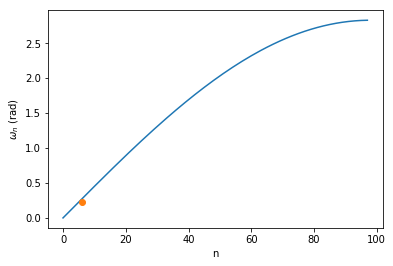

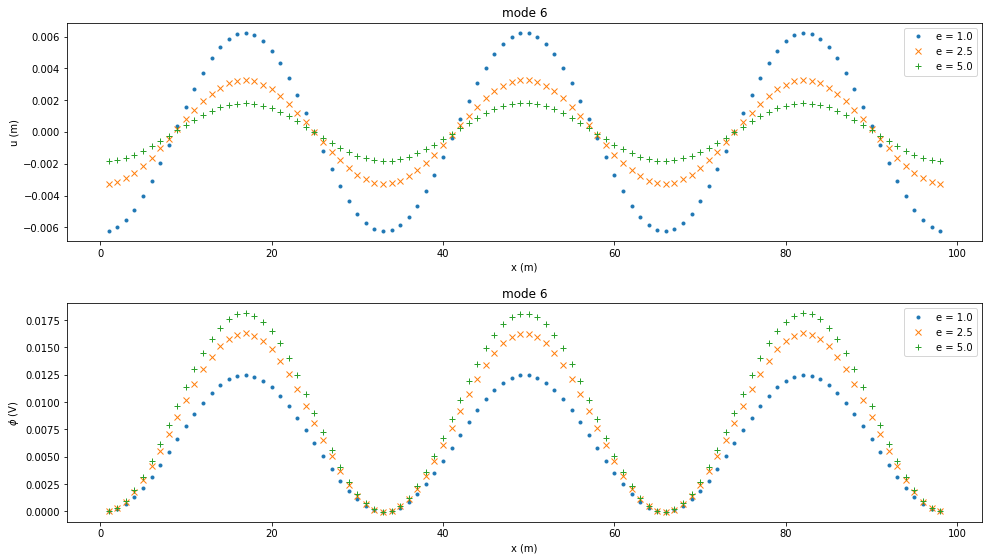

In [5]:
mode_ind = 6


markers = itertools.cycle(['.','x','+'])

plt.figure()
#plot eigenfrequencies
plt.plot(freqs.real)
plt.xlabel("n")
plt.ylabel("$\omega_n$ (rad)")
plt.plot(mode_ind,freqs[mode_ind-1].real, 'o')
plt.show()

plt.figure(figsize=(14,8))
plt.subplot(211)
plt.plot(x[1:-1], -u[:,mode_ind].real, label = f"e = {e1[0]}",  ls = "none", marker = next(markers))
plt.plot(x[1:-1], -u2[:,mode_ind].real, label = f"e = {e2[0]}",  ls = "none", marker = next(markers))
plt.plot(x[1:-1], u3[:,mode_ind].real, label = f"e = {e3[0]}",  ls = "none", marker = next(markers))
# plt.axhline(np.max(np.abs(phi[:,mode_ind])) + np.max(np.abs(u[:,mode_ind])))
# plt.axhline(np.max(np.abs(phi2[:,mode_ind])) + np.max(np.abs(u2[:,mode_ind])))
# plt.axhline(np.max(np.abs(phi3[:,mode_ind])) + np.max(np.abs(u3[:,mode_ind])))
plt.title(f"mode {mode_ind}")
# plt.plot(x[1:-1], u[:,mode_ind].real - u[:,mode_ind].imag)
plt.xlabel("x (m)")
plt.ylabel("u (m)")
plt.legend()


plt.subplot(212)
plt.title(f"mode {mode_ind}")
plt.plot(x[1:-1], -phi[:,mode_ind].real, label = f"e = {e1[0]}", ls = "none", marker = next(markers))
plt.plot(x[1:-1], -phi2[:,mode_ind].real, label = f"e = {e2[0]}", ls = "none", marker = next(markers))
plt.plot(x[1:-1], phi3[:,mode_ind].real, label = f"e = {e3[0]}", ls = "none", marker = next(markers))
# plt.axhline(np.max(np.abs(phi[:,mode_ind])) + np.max(np.abs(u[:,mode_ind])))
# plt.axhline(np.max(np.abs(phi2[:,mode_ind])) + np.max(np.abs(u2[:,mode_ind])))
# plt.axhline(np.max(np.abs(phi3[:,mode_ind])) + np.max(np.abs(u3[:,mode_ind])))
# plt.plot(x[1:-1], phi[:,mode_ind].imag - phi[:,mode_ind].real)
plt.xlabel("x (m)")
plt.ylabel("$\phi$ (V)")
plt.legend()
plt.tight_layout(pad = 1.5)
plt.show()

## Inhomogeneous piezo-electric coefficient

In [6]:
#dummy parameters
N = 100
rho = np.ones(N)
e = 3 * np.ones(N)
c = np.ones(N)
eps = np.ones(N)
x = np.arange(0,N)
dx = x[1] - x[0]

switch_i = N//2

e[switch_i:] = 0
#eps[N//2:] = 0.00010

In [7]:
#now solve the generalized eigenvalue problem
freqs, vecs = piezo_inhomogeneous(x, rho, c, e, eps)

u = vecs[:len(vecs)//2]
phi = vecs[len(vecs)//2:]

Plot the disperison

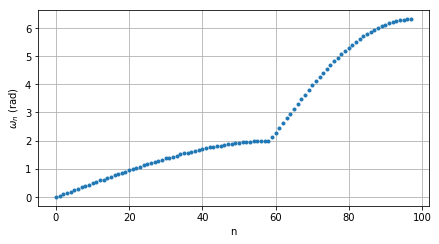

In [8]:
plt.figure(figsize = (7,3.6))
plt.plot(freqs.real, '.')
plt.xlabel("n")
plt.ylabel("$\omega_n$ (rad)")
plt.grid()
plt.savefig("inhom_piezo_dispersion.pdf")
plt.show()

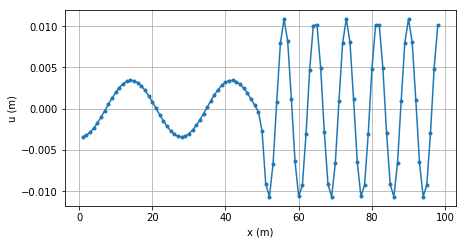

In [9]:
mode_ind = 15


plt.figure(figsize = (7,3.6))
plt.plot(x[1:-1], u[:, mode_ind], '.-')
plt.xlabel("x (m)")
plt.ylabel("u (m)")
plt.savefig("inhom_piezo_mode.pdf")
plt.grid()
plt.show()

find the wavelength

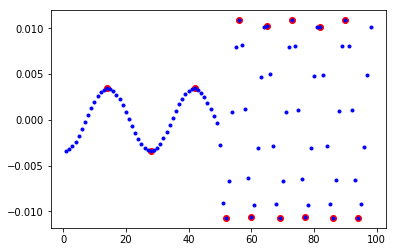

wavelength for the left side:
the wavelenth on the left side = 28.00000000

wavelength for the right side:
the wavelenth on the right side = 8.00000000


In [10]:
specific_mode = u[:, mode_ind]

#find the peaks and valleys, concatenate them into one array, and then sort them
peak_ind = np.sort(np.concatenate((ss.find_peaks(specific_mode)[0], ss.find_peaks(-specific_mode)[0])))

#make a debug plot
plt.plot(x[1:-1][peak_ind], specific_mode[peak_ind], "or")
plt.plot(x[1:-1], specific_mode, 'b.')
plt.show()

#splot the peaks indices array
peak_ind_L = peak_ind[np.where(peak_ind < switch_i)[0]]
peak_ind_R = peak_ind[np.where(peak_ind > switch_i)[0]]

#compute the wavelength on both sides
print("wavelength for the left side:")
if len(peak_ind_L) > 1:
    lamda_L = 2 * (x[1:-1][peak_ind_L[1]] - x[1:-1][peak_ind_L[0]])
    print(f"the wavelenth on the left side = {lamda_L:.8f}")
else:
    print("you need at least 2 internal peaks/valleys. Try a higher mode.")
print("")
print("wavelength for the right side:")
if len(peak_ind_R) > 1:
    lamda_R = 2 * (x[1:-1][peak_ind_R[1]] - x[1:-1][peak_ind_R[0]])
    print(f"the wavelenth on the right side = {lamda_R:.8f}")
else:
    print("you need at least 2 internal peaks/valleys. Try a higher mode.")
    

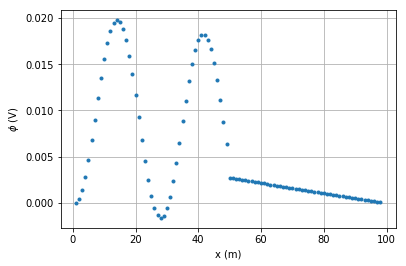

In [11]:
plt.figure()
plt.plot(x[1:-1], phi[:, mode_ind], '.')
plt.xlabel("x (m)")
plt.ylabel("$\phi$ (V)")
plt.savefig("inhom_piezo_phi.pdf")
plt.grid()
plt.show()





It seems like the slope of increasing equilibrium position of oscillation is increasing with the same slope as the potential in the second half. Let us check this:

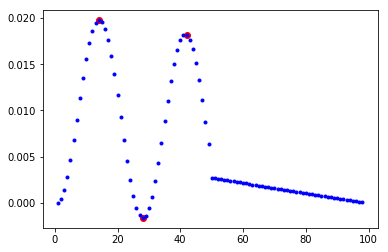

wavelength for the left side:
the wavelenth on the left side = 28.00000000

wavelength for the right side:
you need at least 2 internal peaks/valleys. Try a higher mode.


In [12]:
specific_mode = phi[:, mode_ind]

#find the peaks and valleys, concatenate them into one array, and then sort them
peak_ind = np.sort(np.concatenate((ss.find_peaks(specific_mode)[0], ss.find_peaks(-specific_mode)[0])))

#make a debug plot
plt.plot(x[1:-1][peak_ind], specific_mode[peak_ind], "or")
plt.plot(x[1:-1], specific_mode, 'b.')
plt.show()

#splot the peaks indices array
peak_ind_L = peak_ind[np.where(peak_ind < switch_i)[0]]
peak_ind_R = peak_ind[np.where(peak_ind > switch_i)[0]]

#compute the wavelength on both sides
print("wavelength for the left side:")
if len(peak_ind_L) > 1:
    lamda_L = 2 * (x[1:-1][peak_ind_L[1]] - x[1:-1][peak_ind_L[0]])
    print(f"the wavelenth on the left side = {lamda_L:.8f}")
else:
    print("you need at least 2 internal peaks/valleys. Try a higher mode.")
print("")
print("wavelength for the right side:")
if len(peak_ind_R) > 1:
    lamda_R = 2 * (x[1:-1][peak_ind_R[1]] - x[1:-1][peak_ind_R[0]])
    print(f"the wavelenth on the right side = {lamda_R:.8f}")
else:
    print("you need at least 2 internal peaks/valleys. Try a higher mode.")

/Users/samkatiraee-far/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


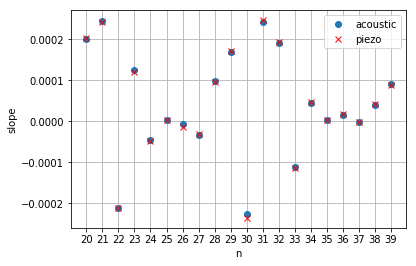

In [13]:
#linear fit function 
def f(x,a,b):
    return a*x + b

a_lins = []
a_waves = []
mode_range = range(20,40)
for mode_ind in mode_range:
    specific_mode = phi[:, mode_ind]
    
    #find the peaks and valleys, concatenate them into one array, and then sort them
    peak_ind = (ss.find_peaks(specific_mode)[0])
    
    #splot the peaks indices array
    peak_ind_L = peak_ind[np.where(peak_ind < (switch_i-1))[0]]
    
    #make names for fitting data
    #x and y for oscillating part
    x_wave = x[1:-1][peak_ind_L]
    y_wave = specific_mode[peak_ind_L]
    
    #x and y for linear part
    x_lin = x[1:-1][switch_i:]
    y_lin = specific_mode[switch_i:]
    
    #obtain coefficient from fit
    (a_wave,b_wave), cov_wave = curve_fit(f, x_wave, y_wave)
    (a_lin, b_lin), cov_wave = curve_fit(f, x_lin, y_lin)
    
    a_waves.append(a_wave)
    a_lins.append(a_lin)
    
    #debug plot
#     plt.plot(x[1:-1], specific_mode, 'b.')
#     plt.plot(x[1:-1], x[1:-1] * a_wave + b_wave)
#     plt.plot(x[1:-1], x[1:-1] * a_lin + b_lin)
#     plt.plot(x[1:-1][peak_ind_L], specific_mode[peak_ind_L], "or")
#     plt.show()
    

    
plt.plot(mode_range, a_lins, 'o', label = "acoustic")
plt.plot(mode_range, a_waves, 'x', c ="red", label = "piezo")
plt.xlabel("n")
plt.ylabel("slope")
plt.xticks(mode_range)
plt.legend()
plt.grid()
plt.savefig("slopes.pdf")
plt.show()
    
    

    

It indeed is the case!

# solution using real parameters

## Investigation of how long it takes

Since we will need loads of points, let us check how long it takes to run for different N



In [16]:
from time import time

N_start = 100
N_end = 2000
N_step = 100

N_range = range(N_start,N_end+N_step,N_step)
# times = []
# for N in N_range:
#     rho = np.ones(N)
#     e = 1 * np.ones(N)
#     c = np.ones(N)
#     eps = np.ones(N)
#     x = np.arange(0,N)
#     dx = x[1] - x[0]
    
#     switch_i = N//2

#     e[switch_i:] = 0
    
    
#     #now solve the generalized eigenvalue problem
#     t1 = time()
#     freqs, vecs = piezo_inhomogeneous(x, rho, c, e, eps)
#     t2 = time()

#     u = vecs[:len(vecs)//2]
#     phi = vecs[len(vecs)//2:]
    
#     times.append(t2-t1)
#     print(f"finished N = {N} in {t2-t1} seconds")
    

    
    
    
    


In [17]:
def f(N,a,b):
    return a * N**b

(a,b), covs = curve_fit(f, N_range, times)




NameError: name 'times' is not defined

for N = (100,1000) the obtained parameters were a = 1.669e-9, b = 3.518 <br/>
for N = (100,2000) the obtained parameters were a = 5.33e-9, b = 3.347

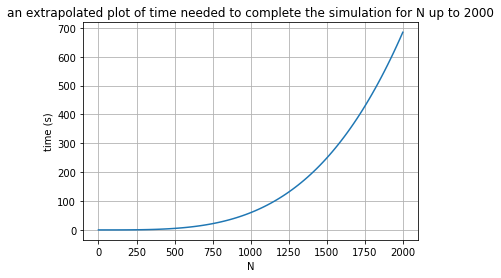

In [18]:
N_desired = 2000
N_fit = np.linspace(0,N_desired,100)
plt.title(f"an extrapolated plot of time needed to complete the simulation for N up to {N_desired}")
plt.plot(N_fit, f(N_fit,1.669e-9, 3.518))
plt.xlabel("N")
plt.ylabel("time (s)")
plt.grid()
plt.show()

## Application to the model

Material properties in quesiton

In [19]:
rho_AlN = 3260 #(kg/m^3)
rho_Sap = 3980 #(kg/m^3)

e_AlN = 1.5 #(C/m^2)
e_Sap = 0 

c_AlN = 395e9 #(Pa)
c_Sap = 345e9 #(Pa)

epsr_AlN = 10.5 #(-)
epsr_Sap = 11.5 #(-)

eps0 = 8.85419e-12 #F/m

In [36]:
#number of points
N = 1000

#create x array
x0 = 0
x1 = 50e-6
x_int = 1e-6

x = np.linspace(x0,x1,N)
switch_i = np.where(x>x_int)[0][0]


rho = np.zeros(N)
c = np.zeros(N)
e = np.zeros(N)
eps = np.zeros(N)

#set the coefficient arrays
rho[:switch_i] = rho_AlN      
rho[switch_i:] = rho_Sap

c[:switch_i]   = c_AlN          
c[switch_i:]   = c_Sap

e[:switch_i]   = e_AlN        
e[switch_i:]   = e_Sap

eps[:switch_i] = epsr_AlN * eps0
eps[switch_i:] = epsr_Sap * eps0

In [37]:
#now solve the generalized eigenvalue problem
time1 = time()
freqs, vecs = piezo_inhomogeneous(x, rho, c, e, eps, rescale_u=1e-3, rescale_phi=1e6)
time2 = time()

u = vecs[:len(vecs)//2]
phi = vecs[len(vecs)//2:]

In [35]:
np.savetxt(f"full_shebang_results/N={N}_xi={x_int}_L={x1}_t={time2-time1:.2f}", vecs)

In [23]:
elapsed_time = time2-time1
print(elapsed_time)

0.04478716850280762


/Users/samkatiraee-far/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


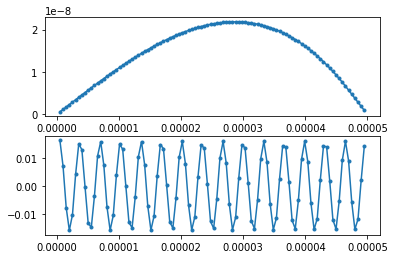

In [34]:
plt.subplot(211)
plt.plot(x[1:-1],phi[:,30], '.-')
plt.subplot(212)
plt.plot(x[1:-1], u[:, 30], '.-')


